In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyrolite.comp import pyrocomp
from sklearn.model_selection import train_test_split
import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from scipy.signal import savgol_filter
from lightgbm import LGBMRegressor
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost 

import sklearn.ensemble
import sklearn.model_selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
import pysptools.spectro as spectro

from concurrent.futures import ThreadPoolExecutor, as_completed
import random
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from sklearn.utils import resample

# Codes for hyperparameters optimization

In [30]:
optuna.logging.set_verbosity(optuna.logging.INFO)

# Define a custom scoring function using r2_score
def custom_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

def objective_rfr(trial):
    param = {
        'random_state': 48,
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 1.0),
    }

    regressor_obj = RandomForestRegressor(**param)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_xgbr(trial):
        
    param = {
        'max_depth' : trial.suggest_int("max_depth", 3, 12),
        'gamma' : trial.suggest_float ("gamma", 0,5),
        'learning_rate' : trial.suggest_float ("eta", 0.01, 0.05),
        'subsample' : trial.suggest_float ("subsample", 0.5, 1),
        'colsample_bytree' : trial.suggest_float ("xgbr_colsample_bytree", 0.5, 1),
        'min_child_weight' : trial.suggest_int ("min_child_weight", 1, 10)
        }
    
    regressor_obj = xgboost.XGBRegressor(**param)  
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_lgbr(trial):
    
    param = {
        'metric': 'mae', 
        'random_state': 48,
        'n_estimators': trial.suggest_int ('n_estimators', 10, 15000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1000),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }
    regressor_obj = LGBMRegressor(**param)  
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_svr(trial):
    
    param = {
        'kernel': trial.suggest_categorical("kernel", ["linear", "rbf"]),
        'degree': trial.suggest_int ('degree', 1, 5),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1),
        'epsilon': trial.suggest_loguniform('epsilon', 1e-3, 0.1),
        'C': trial.suggest_float('C', 0.1, 2),
    }
    regressor_obj = SVR(**param)  
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()

def objective_plsr(trial):
    
    param = {
        'n_components': trial.suggest_int ('n_components', 2, 8),
        'tol':trial.suggest_float ('tol', 1e-8, 1e-2),
        'scale':trial.suggest_categorical ('scale', [True, False])
    }
    regressor_obj = PLSRegression(**param)  
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor_obj, X_train, y_train, cv=cv, scoring=make_scorer(custom_scorer))
    return scores.mean()


## Import données
Ce jeu de données contient les données de bassin contenant : 
- intervalles de composites de géochimie
- spectres moyennés par intervalles de géochimie
- résistivité (RLLD) moyenné sur les mêmes intervalles
- les données censurées de géochimie ont été corrigées (cf article).

On essaie de prédire la résistivité à partir de la géochimie/spectral. On teste différents scénarios : 
- Random train-test split vs drillhole based train-test split (une prédiction robuste doit obtenir des résultats similaires sur les deux méthodes d'échantillonnage)
- Différents algos
- Différents scénarios (spectroscopie seule avec différents traitements,


In [3]:
data = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Clean_Data\Logs_Basement.csv')

## add a filler variable
data.insert(data.columns.get_loc('Zr') + 1, 'Filler', 1000000 - data[data.loc[:, 'Ag':'Zr'].columns].sum(axis=1))

## remove invalid values
data.drop(data[data['LogRLLD'] < 0].index, inplace=True)

## Spectral trimming of 'noisiest' wavelengths
spectral = data.loc[:, '500':'2400']

## Continuum removal

In [4]:
## load already computed continuum removed spectra : 
#np.save (stock[0], r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Clean_Data\CR_Spectra.npy')
wvl = np.arange(350, 2498, 1)

removed_spectra = np.load(r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Clean_Data\CR_Spectra_BST.npy')
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)


In [4]:
spectral = data.loc[:, '350':'2498']

#wavelength array
wvl = np.arange(350, 2498, 1)

# Function to apply convex hull removal
def remove_convex_hull(spectrum):
    removed = spectro.convex_hull_removal(spectrum, wvl)
    return removed[0]

# apply the function to each row
with tqdm(total=len(data), desc="Processing Spectra") as pbar:
    removed_spectra = []
    for _, row in spectral.iterrows():
        removed_spectra.append(remove_convex_hull(row))
        pbar.update(1)
stock = np.array([removed_spectra])
removed_spectra = pd.DataFrame (removed_spectra, columns = wvl)

## dataframe with continuum removed spectra
data_cr = pd.concat ([data.loc[:, 'HoleName':'Filler'], removed_spectra], axis = 1, sort = False)



Processing Spectra: 100%|██████████████████████████████████████████████████████████| 1701/1701 [04:19<00:00,  6.56it/s]


# Blind well test-train split

In [5]:
## Séparation d'un jeu de données externe (Getty Russell)
## data si on utilise les spectres bruts // data_cr si on utilise les spectres corrigés du continuum
data_ml = data_cr.loc[data_cr['Project'] != 'GET']
data_get = data_cr.loc[data_cr['Project'] == 'GET']

## Sélection de 25% des forages pour le train/test split
#holenames = sandstone_ml['HoleName'].unique().tolist()
#num_elements_to_select = int(len(holenames) * 25 / 100)
#testing_holenames = random.sample(holenames, num_elements_to_select)
#training_holenames = [name for name in holenames if name not in testing_holenames]

## Pour reprendre le train-test split utilisé dans l'article, utiliser : 
testing_holenames = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Train_Test_Split\Testing_HoleNames.csv').iloc[:, 1].tolist()
training_holenames = pd.read_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Data\Train_Test_Split\Training_HoleNames.csv').iloc[:, 1].tolist()

testing_data = data_ml[data_ml['HoleName'].isin(testing_holenames)]

training_data = data_ml[data_ml['HoleName'].isin(training_holenames)]



# Pre-Processing

In [28]:
###
### TRAINING DATA
###

geochem_training = training_data.loc[:, 'Ag':'Filler']
ir_training = training_data.loc[:, 500:2400]
ir_training = pd.DataFrame(savgol_filter(ir_training, 25, polyorder = 2, deriv = 1)) ## Changer cela pour tester différents scénarios de traitement IR

#geochem_ilr_training = geochem_training.pyrocomp.ILR()
geochem_clr_training = geochem_training.pyrocomp.CLR()

## PWLR

element_pairs = [(element1, element2) for element1 in geochem_training.columns for element2 in geochem_training.columns if element1 < element2]
log_ratios_list = []

for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_training[element1] / geochem_training[element2])
    log_ratios_list.append(pd.Series(log_ratios, name=log_ratio_column))
    
geochem_pwlr_training = pd.concat(log_ratios_list, axis=1)

###
### TESTING DATA
###

geochem_testing = testing_data.loc[:, 'Ag':'Filler']
ir_testing = testing_data.loc[:, 500:2400]
ir_testing = pd.DataFrame(savgol_filter(ir_testing, 25, polyorder = 2, deriv = 1))

#geochem_ilr_testing = geochem_testing.pyrocomp.ILR()
geochem_clr_testing = geochem_testing.pyrocomp.CLR()

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_testing.columns for element2 in geochem_testing.columns if element1 < element2]
log_ratios_list = []

for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_testing[element1] / geochem_testing[element2])
    log_ratios_list.append(pd.Series(log_ratios, name=log_ratio_column))
    
geochem_pwlr_testing = pd.concat(log_ratios_list, axis=1)


## Choix du scénario

In [7]:
geochem_pwlr_training = geochem_pwlr_training.reset_index(drop=True)
geochem_clr_training = geochem_clr_training.reset_index(drop=True)

geochem_pwlr_testing = geochem_pwlr_testing.reset_index(drop=True)
geochem_clr_testing = geochem_clr_testing.reset_index(drop=True)

# Choisir un scénario de données d'entraînement : ir_training, geochem_pwlr_training,... ou bien concaténer plusieurs jeux de données pour l'entrainement
X_train = pd.concat([geochem_pwlr_training, ir_training], axis=1)
X_train = geochem_clr_training
X_train.columns = X_train.columns.astype(str)

y_train = (training_data['LogRLLD']) 

## Choisir le même jeu de données pour le jeu de données test
X_test = pd.concat([geochem_pwlr_testing, ir_testing], axis=1)
X_test = geochem_clr_testing
X_test.columns = X_test.columns.astype(str)


#X_test = geochem_pwlr_testing

y_test = (testing_data['LogRLLD'])



## Training

In [8]:
best_trials = {}

n_jobs = 8 ## nombre de workers à utiliser
n_trials = 100

# models and their corresponding objective functions ; uncomment to test different alforithms
models = [
   #('PLSR', objective_plsr), 
   ('LGBR', objective_lgbr),
    #('XGBR', objective_xgbr),
    #('RFR', objective_rfr),
   #('SVR', objective_svr)
]

for model_name, objective_function in models:
    print(model_name)

    progress_bar = tqdm(total=n_trials, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def objective_with_progress_bar(trial):
        result = objective_function(trial)
        progress_bar.update(1)
        return result

    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_progress_bar, n_trials=n_trials, n_jobs=n_jobs)
    best_trials[model_name] = study.best_trial
    optuna.logging.set_verbosity(optuna.logging.INFO)
    progress_bar.close()

# evaluation on test dataset using cv
def evaluate_model_cv(model, X_test, y_test, progress_bar=None):
    y_pred = cross_val_predict(model, X_test, y_test, cv=5)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    if progress_bar:
        progress_bar.update(1)

    return rmse, r2

# launch models and get R² + rmse on validation dataset
for model_name, trial in best_trials.items():
    print(model_name)

    progress_bar = tqdm(total=1, position=0, leave=True, desc=model_name,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

    def evaluate_with_progress_bar(X_test, y_test):
        model = None

        if model_name == 'PLSR':
            model = PLSRegression(n_components=trial.params['n_components'])
        elif model_name == 'LGBR':
            model = LGBMRegressor(**trial.params)
        elif model_name == 'XGBR':
            model = xgboost.XGBRegressor(**trial.params)
        elif model_name == 'RFR':
            model = RandomForestRegressor(**trial.params)
        elif model_name == 'SVR':
            model = SVR(**trial.params)

        model.fit(X_train, y_train)
        rmse, r2 = evaluate_model_cv(model, X_test, y_test, progress_bar)
        print(f"{model_name} - R²: {r2}, RMSE: {rmse}")

    evaluate_with_progress_bar(X_test, y_test)

    progress_bar.close()

LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00]


LGBR


LGBR: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00]

LGBR - R²: 0.7140601516302583, RMSE: 0.4067326367541435


## Prediction intervals

In [13]:
## Bootstrap resampling to estimate prediction intervals on the selected model

# train model
rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)
print(rerun_lbgm)

y_bootstrap = []
# bootstrap predictions
accuracy = []
n_iterations = 5
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 800)
    rerun_lbgm.fit(X_bs,y_bs)
    # make predictions
    y_hat = rerun_lbgm.predict(X_test)
    print(i)
    y_bootstrap.append(y_hat)
    
    # evaluate model
    
y_boostrap = pd.DataFrame(np.vstack(y_bootstrap))

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.04138526373125681,
              max_depth=7, min_child_samples=7, n_estimators=8570,
              num_leaves=580, reg_alpha=0.009899312971559845,
              reg_lambda=3.4434426259380464, subsample=0.4)
0
1
2
3
4


## Scatterplots prédictions

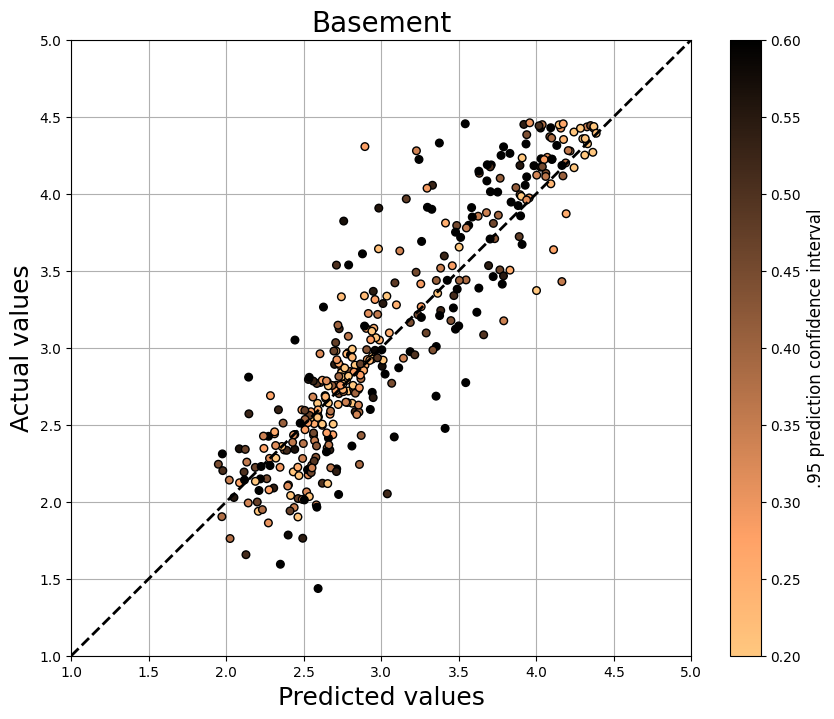

In [16]:
uncertainty = pd.DataFrame(y_bootstrap).std(axis = 0)
mean = pd.DataFrame(y_bootstrap).mean(axis = 0)
y_hat = rerun_lbgm.predict(X_test)
plt.rc('axes', axisbelow=True)

upper_ci = mean + (1.96 * uncertainty)
lower_ci = mean -( 1.96 * uncertainty)
ci_difference = upper_ci - lower_ci

diff = pd.DataFrame(ci_difference, columns = ['CI']).reset_index()
y1 = pd.DataFrame(y_hat, columns = ['Predicted']).reset_index()
y2 = pd.DataFrame(y_test).reset_index()
matrix = pd.concat ([diff, y1, y2], sort = False, axis = 1)

plt.figure (2, figsize = (10, 8))
plt.xlabel ('Predicted values', fontsize = 18)
plt.ylabel ('Actual values', fontsize = 18)
plt.grid(True)
plt.scatter (matrix['Predicted'], matrix['LogRLLD'], c = matrix['CI'], cmap = 'copper_r', vmin = 0.2, vmax = 0.6, marker = 'o', s = 30, edgecolor = 'black', linewidth = 1)
clb = plt.colorbar()
clb.set_label('.95 prediction confidence interval')
plt.xlim (1, 5)
plt.ylim (1, 5)
plt.title ('Basement', fontsize = 20)
plt.plot([1, 5], [1, 5], linestyle='--', color='black', linewidth=2, label='y=x')

##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Scatterplot_Basement_IR.png')
##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Scatterplot_Basement_IR.pdf')
plt.show()



## Features importance

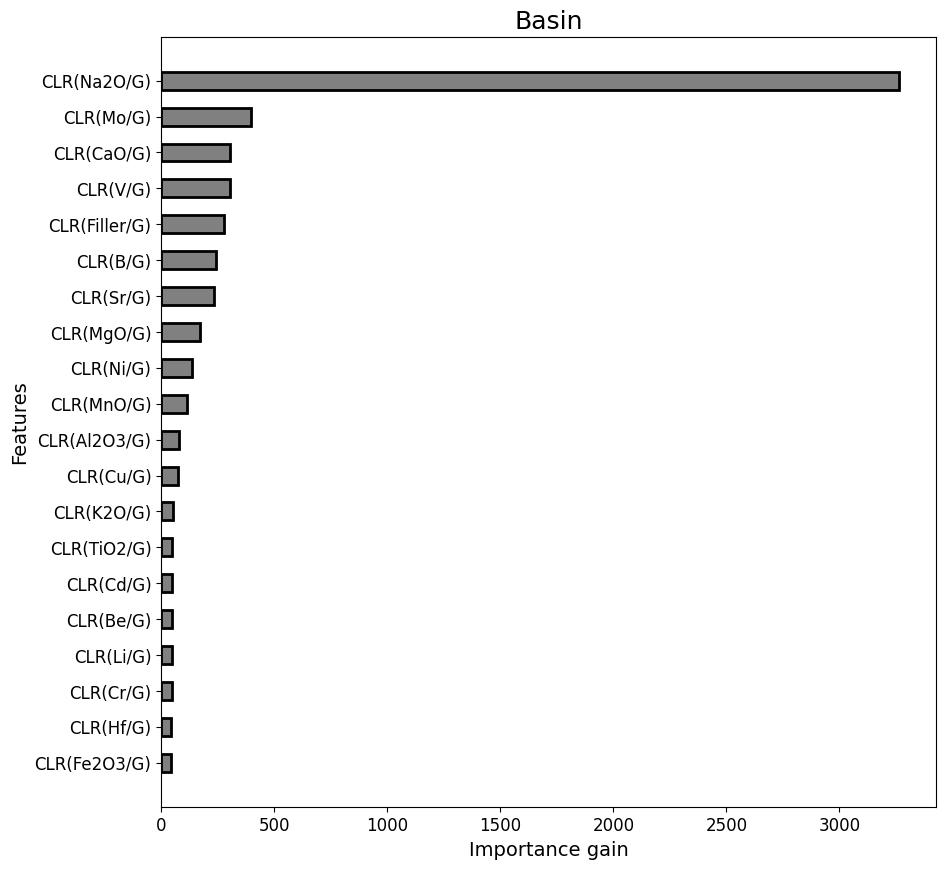

In [17]:
## Feature importance

rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)
rerun_lbgm.fit (X_train, y_train)

# Get feature importance values
features = pd.concat([X_train], axis=1)
features.columns = features.columns.astype(str)

feature_names = features.columns
importance_values = rerun_lbgm.booster_.feature_importance(importance_type='gain')

# Sort features by importance
sorted_indices = np.argsort(importance_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Plot custom bar chart
fig, ax = plt.subplots(figsize=(10, 10))

bar_colors = 'grey'
bar_height = 0.5  

ax.barh(sorted_feature_names[:20][::-1], sorted_importance_values[:20][::-1], color=bar_colors, height=bar_height, edgecolor='black', linewidth=2)

ax.set_title('Basement', fontsize=18)
ax.set_xlabel('Importance gain', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Features_Basement_IR.png', bbox_inches = 'tight')
##plt.savefig (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Figures\Results\Features_Basement_IR.pdf', bbox_inches = 'tight')
plt.show()

## Prediction on the external dataset

In [20]:
data_get[500]

0      0.871740
1      0.883270
2      0.834769
3      0.998305
4      0.826278
         ...   
283    0.979686
284    0.994247
285    0.995864
286    0.927401
287    0.995995
Name: 500, Length: 288, dtype: float64

In [31]:
## Preprocessing Getty Russell
ir_get = data_get.loc[:, 500:2400]
ir_get = pd.DataFrame(savgol_filter(ir_get, 25, polyorder = 2, deriv = 1))

geochem_get = data_get.loc[:, 'Ag':'Filler']
geochem_clr_get = geochem_get.pyrocomp.CLR()
##geochem_ilr_get = geochem_get.pyrocomp.ILR()

## PWLR
element_pairs = [(element1, element2) for element1 in geochem_get.columns for element2 in geochem_get.columns if element1 < element2]
log_ratios_list = []

for element1, element2 in element_pairs:
    log_ratio_column = f"{element1}/{element2}"
    log_ratios = np.log(geochem_get[element1] / geochem_get[element2])
    log_ratios_list.append(pd.Series(log_ratios, name=log_ratio_column))
    
geochem_pwlr_get = pd.concat(log_ratios_list, axis=1)


# Concatenate side by side
X_get = geochem_clr_get
X_get.columns = X_get.columns.astype(str)

y_get = (data_get['LogRLLD'])

####

In [24]:
## Prediction on the external dataset
rerun_lbgm.fit(X_train,y_train)

y_c = pd.DataFrame(rerun_lbgm.predict(X_get))

y_c.columns = ['Predicted_values']

## Uncertainty prediction
rerun_lbgm = LGBMRegressor (**best_trials['LGBR'].params)

y_bootstrap_get = []
# bootstrap predictions
accuracy = []
n_iterations = 5
for i in range(n_iterations):
    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples = 1000)
    rerun_lbgm.fit(X_bs,y_bs)
    # make predictions
    y_hat = rerun_lbgm.predict(X_get)
    print(i)
    y_bootstrap_get.append(y_hat)
    
y_bootstrap_get = pd.DataFrame(np.vstack(y_bootstrap_get))

##
uncertainty = pd.DataFrame(y_bootstrap_get).std(axis = 0)
mean = pd.DataFrame(y_bootstrap_get).mean(axis = 0)
y_hat = rerun_lbgm.predict(X_get)

upper_ci = mean + 1.96 * uncertainty
lower_ci = mean - 1.96 * uncertainty
ci_difference = upper_ci - lower_ci


0
1
2
3
4


## Mise en forme et export pour logs synthétiques

In [25]:
actual_values = data_get['LogRLLD']
predicted_values = y_c
min_ci = pd.DataFrame(lower_ci, columns = ['Lower_CI'])
max_ci = pd.DataFrame(upper_ci, columns = ['Upper_CI'])
collar = data_get.loc[:, 'HoleName':'SAMPTO']

actual_values = actual_values.reset_index(drop = True)
predicted_values = predicted_values.reset_index(drop = True)
min_ci = min_ci.reset_index(drop = True)
max_ci = max_ci.reset_index(drop = True)
collar = collar.reset_index(drop = True)

prediction_get = pd.concat ([collar, actual_values, predicted_values, min_ci, max_ci], axis = 1, sort = False)

prediction_get

,HoleName,SAMPFROM,SAMPTO,LogRLLD,Predicted_values,Lower_CI,Upper_CI
0,GRL161A,250.8,270.0,4.122643,3.722356,3.437336,3.832592
1,GRL161A,270.0,290.0,4.084798,3.694087,3.439408,3.752218
2,GRL161A,290.0,301.8,3.850907,3.621736,3.382665,3.795083
3,GRL161A,301.8,306.0,2.696946,2.621977,2.590908,2.872025
4,GRL161A,306.0,315.0,2.577457,2.644233,2.581718,2.738632
...,...,...,...,...,...,...,...
283,GRL221,268.0,275.1,4.056708,3.274763,3.043193,3.508070
284,GRL221,275.1,287.2,1.725125,2.251538,2.258116,2.477446
285,GRL221,287.2,299.3,1.409420,2.316019,2.078603,2.522690
286,GRL221,299.3,311.2,3.786932,3.471429,3.173347,3.662129


In [91]:
prediction_get.to_csv (r'C:\Users\serdoun1\Desktop\Article_Petrophysics\Results\Prediction_GET_Basement.csv')